# Assignment 4_LI XINYA

## Import the libraries

In [2]:
import pandas as pd
import numpy as np
import os
import glob
import random
import shutil
from shutil import copy2
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Generate the label file, split datasets

In [3]:
 def data_set_split(src_data_folder, target_data_folder, train_scale=0.8, val_scale=0.2):
        
    class_names = os.listdir(src_data_folder)
    split_names = ['train', 'val']
    for split_name in split_names:
        split_path = os.path.join(target_data_folder, split_name)
        if os.path.isdir(split_path):
            pass
        else:
            os.mkdir(split_path)
        
        for class_name in class_names:
            class_split_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_split_path):
                pass
            else:
                os.mkdir(class_split_path)

    for class_name in class_names:
        current_class_data_path = os.path.join(src_data_folder, class_name)
        current_all_data = os.listdir(current_class_data_path)
        current_data_length = len(current_all_data)
        current_data_index_list = list(range(current_data_length))
        random.shuffle(current_data_index_list)

        train_folder = os.path.join(os.path.join(target_data_folder, 'train'), class_name)
        val_folder = os.path.join(os.path.join(target_data_folder, 'val'), class_name)
        train_stop_flag = current_data_length * train_scale
        val_stop_flag = current_data_length * (train_scale + val_scale)
        current_idx = 0
        train_num = 0
        val_num = 0
        for i in current_data_index_list:
            src_img_path = os.path.join(current_class_data_path, current_all_data[i])
            if current_idx <= train_stop_flag:
                copy2(src_img_path, train_folder)
                train_num = train_num + 1
            elif (current_idx > train_stop_flag) and (current_idx <= val_stop_flag):
                copy2(src_img_path, val_folder)
                val_num = val_num + 1

            current_idx = current_idx + 1

src_data_folder = "C:/Users/ameli/Desktop/semester 2/07/Assignment 4/BS6207-assignment4/src_data"
target_data_folder = "C:/Users/ameli/Desktop/semester 2/07/Assignment 4/BS6207-assignment4/target_data"
data_set_split(src_data_folder, target_data_folder)

## Load the datasets, do the preprocessing

In [4]:
preprocess = torchvision.transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [5]:
train_dataset =torchvision.datasets.ImageFolder(root='target_data/train',transform=preprocess)
train_loader =DataLoader(train_dataset,batch_size=32, shuffle=True)

val_dataset =torchvision.datasets.ImageFolder(root='target_data/val',transform=preprocess)
val_loader =DataLoader(train_dataset,batch_size=32, shuffle=True)

test_dataset =torchvision.datasets.ImageFolder(root='target_data/test',transform=preprocess)
test_loader =DataLoader(train_dataset,batch_size=32, shuffle=True)

labels = ['artifacts', 'cancer', 'normal', 'other']

## Build a CNN

In [6]:
epoches = 10
lr = 0.001
weight_decay=0
batch_size=32

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        # the first layer
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding=1, stride=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # the second layer
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding=1, stride=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # the third layer
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding=1, stride=2)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # the output layer
        self.output1 = nn.Linear(in_features=1024, out_features=512)
        self.dropout = nn.Dropout(p=0.2)
        self.output2 = nn.Linear(in_features=512, out_features=4)
        
        
    def forward(self, x):
        
        # the first layer
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # the second layer
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # the third layer
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        # the output layer
        x = torch.flatten(x,1)
        x = F.relu(self.output1(x))
        x = self.dropout(x)
        output = self.output2(x)
        
        return output

In [7]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output1): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output2): Linear(in_features=512, out_features=4, bias=True)
)


In [7]:
import torch.optim as optim
# Define optimizer and loss function
optimizer = optim.Adam(cnn.parameters(), lr=lr)
loss_function = nn.CrossEntropyLoss()
optimizer_name = 'Adam'

best_val_acc = 0
patience = 0
train_running_loss = 0.0
PATH = 'model/'+'batchsize'+str(batch_size)+'_'+optimizer_name+'_lr'+str(lr)+'_weightDecay'+str(weight_decay)+'.pth'


for epoch in range(epoches):
    print('Processing the {} epoch'.format(epoch))
    loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = cnn(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = cnn(images)
            loss = loss_function(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    cur_val_acc = correct / total
    if cur_val_acc > best_val_acc:
        best_val_acc = cur_val_acc
        torch.save(cnn.state_dict(), PATH)
        patience = 0
    else:
        patience+=1
        
    if patience == 10:
        print('Model is overfit!')
        break
        
    print('epoch' + str(epoch) + ' :validation loss: '+str(val_running_loss/len(val_loader))+', validation accuracy: '+ str(correct / total))

Processing the 0 epoch
epoch0 :validation loss: 0.44124635770553494, validation accuracy: 0.8379537448307551
Processing the 1 epoch
epoch1 :validation loss: 0.33224927739399235, validation accuracy: 0.8816051462704855
Processing the 2 epoch
epoch2 :validation loss: 0.2231911449397846, validation accuracy: 0.9156072905498545
Processing the 3 epoch
epoch3 :validation loss: 0.11316911774437602, validation accuracy: 0.960637157298208
Processing the 4 epoch
epoch4 :validation loss: 0.1496759559983308, validation accuracy: 0.9451677132792158
Processing the 5 epoch
epoch5 :validation loss: 0.061764819631573514, validation accuracy: 0.9796293459947925
Processing the 6 epoch
epoch6 :validation loss: 0.08192057683382456, validation accuracy: 0.9695206003982233
Processing the 7 epoch
epoch7 :validation loss: 0.08214488843364273, validation accuracy: 0.9693674375861541
Processing the 8 epoch
epoch8 :validation loss: 0.0438032423930364, validation accuracy: 0.9840710675448001
Processing the 9 epoch

## After run the above cnn several times with different batch size, put the validation result into csv file.

In [8]:
Batch_size = pd.read_csv('Batch size.csv',index_col = 0, header = 0)
Batch_size

,16,32,64,128
1,0.623,0.656,0.849,0.783
2,0.678,0.687,0.892,0.786
3,0.784,0.754,0.948,0.823
4,0.763,0.798,0.955,0.876
5,0.721,0.812,0.965,0.899
6,0.885,0.823,0.978,0.902
7,0.832,0.856,0.982,0.890
8,0.901,0.899,0.989,0.925
9,0.911,0.899,0.977,0.913
10,0.896,0.900,0.982,0.932


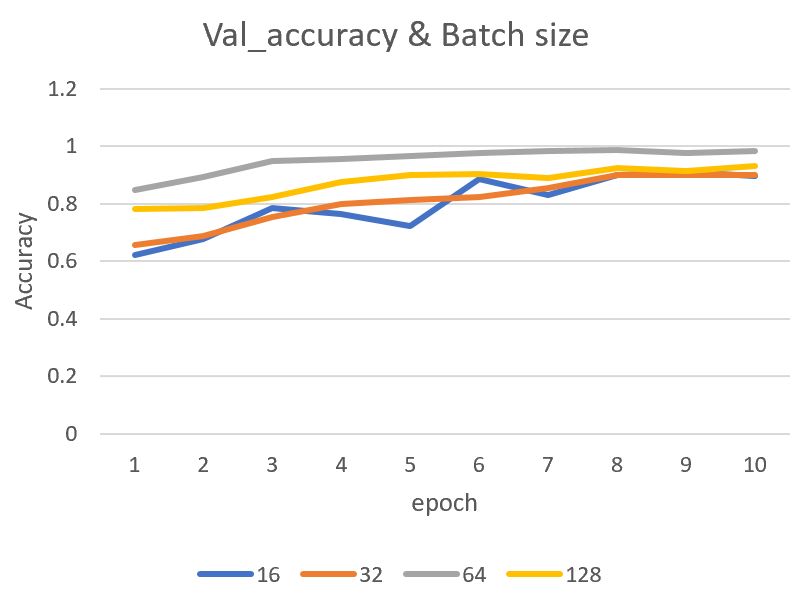

In [12]:
PATH = 'model/batchsize64_Adam_lr0.001_weightDecay0.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy: '+ str(100 * correct / total))

Accuracy: 98.92786031551539
